In [ ]:
# Import packages
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    
import numpy as np
import pandas as pd
import json
import calendar, datetime
from nltk.corpus import stopwords
import string
from scipy import sparse
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import neighbors
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline

In [139]:
# Load dataset
file_path = 'dataset/Musical_Instruments_5.json'
with open(file_path) as f:
    file_content = f.read()
    
output = [json.loads(line)
          for line in file_content.split("\n") if line.strip() != ""]
df_unproc = pd.DataFrame(output)
df_unproc.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [140]:
# First, rows with no review text, duplicate lines, are deleted.
df = df_unproc[~pd.isnull(df_unproc['reviewText'])]
df.drop_duplicates(subset=['reviewerID', 'asin', 'unixReviewTime'], inplace=True)
df.reset_index(inplace=True)
df.head()

# The second step was to create a column that contains the results from the 
# division of helpful numerator and helpful denominator and then to segment 
# these values into bins. 
df['helpful_numerator'] = df['helpful'].apply(lambda x: eval(str(x))[0])
df['helpful_denominator'] = df['helpful'].apply(lambda x: eval(str(x))[1])
df['helpful%'] = np.where(df['helpful_denominator'] > 0, df['helpful_numerator'] / df['helpful_denominator'], -1)
df['helpfulness_range'] = pd.cut(x=df['helpful%'], bins=[-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0],
                                         labels=['empty', '1', '2', '3', '4', '5'], include_lowest=True)

df.reset_index(drop=True, inplace=True)
df.head(3)

,index,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_numerator,helpful_denominator,helpful%,helpfulness_range
0,0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014",0,0,-1.000000,empty
1,1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013",13,14,0.928571,5
2,2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013",1,1,1.000000,5


## EDA

In [141]:
a = list(calendar.day_name)
df['review_weekday'] = df['reviewTime'].apply(lambda x: datetime.datetime.strptime(str(x),'%m %d, %Y').weekday())
df['review_weekday'] = df['review_weekday'].apply(lambda x: a[x])

print(df.groupby('review_weekday')['helpful%'].mean())

review_weekday
Friday      -0.365410
Monday      -0.403573
Saturday    -0.384730
Sunday      -0.446125
Thursday    -0.408174
Tuesday     -0.406900
Wednesday   -0.387120
Name: helpful%, dtype: float64


<AxesSubplot:xlabel='helpfulness_range', ylabel='overall'>

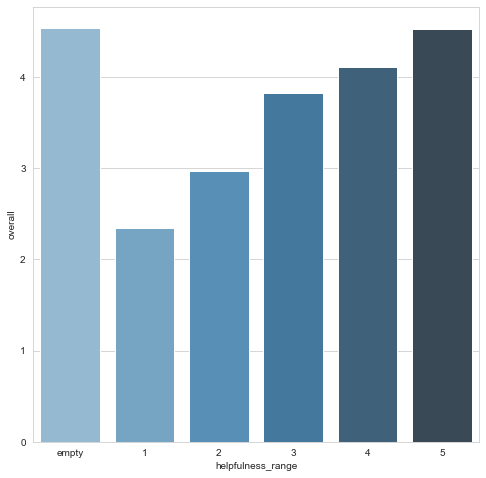

In [255]:
# Rates vs helpfulness range
df1 = pd.DataFrame(df.groupby('helpfulness_range')['overall'].mean().reset_index())
fig = plt.figure(figsize=(8,8))
sns.barplot(x=df1['helpfulness_range'], y=df1['overall'], palette="Blues_d") # there is a connection between high overall score and review score

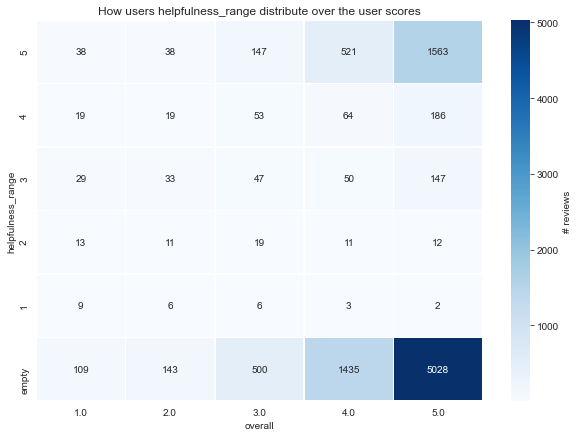

In [267]:
# How users helpfulness_range distribute over the user scores
df1 = df.groupby(['overall', 'helpfulness_range']).agg({'reviewerID': 'count'})
df1 = df1.unstack()
df1.columns = df1.columns.get_level_values(1)
fig = plt.figure(figsize=(10,7))
sns.heatmap(df1[df1.columns[::-1]].T, cmap = 'Blues', linewidths=.5, annot = True, fmt = 'd', cbar_kws={'label': '# reviews'})
plt.title('How users helpfulness_range distribute over the user scores')
plt.show()

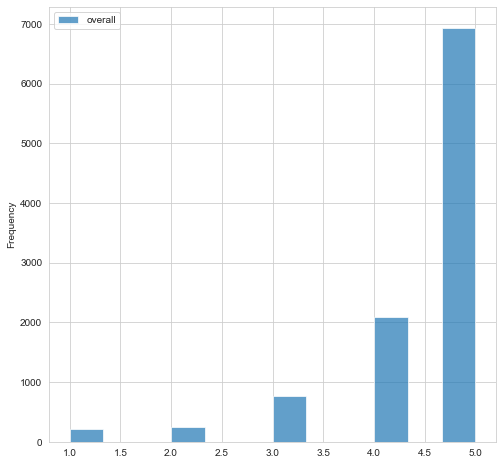

In [268]:
# Rates histogram
df1 = df[["overall"]]
ax = df1.plot.hist(bins=12, alpha=0.7, figsize=(8,8))

In [275]:
df.groupby(["overall"])["index"].count().reset_index(name="count")

,overall,count
0,1.0,217
1,2.0,250
2,3.0,772
3,4.0,2084
4,5.0,6938


In [180]:
df['review_year'] = df['reviewTime'].apply(lambda x: datetime.datetime.strptime(str(x),'%m %d, %Y').year)

(0.0, 4100.0)

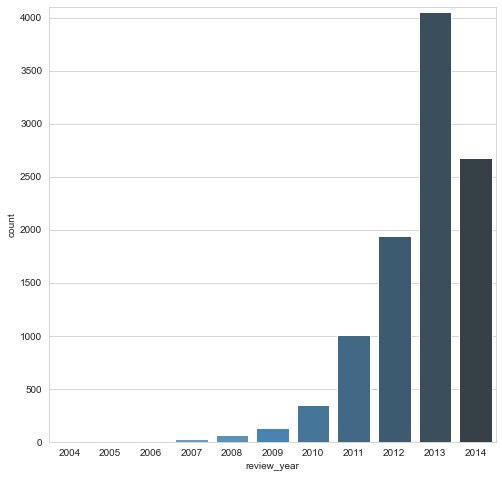

In [264]:
# Number of the reviews over the years
df1 = df.groupby(["review_year"])["index"].count().reset_index(name="count")
fig = plt.figure(figsize=(8,8))
sns.barplot(x=df1['review_year'], y=df1['count'], palette="Blues_d") 
plt.ylim(0, 4100)